In [12]:
# Импорты библиотек для проекта
import re

import os
import glob

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm # для qq plot

from scipy.stats import shapiro # тест на нормальность распределения Шапиро
from scipy.stats import normaltest # тест на нормальность распределения Деагостино
from scipy.stats import mannwhitneyu # тест Манна-Уитни непараметрический тест
from scipy.stats import ttest_ind # t-тест
from statsmodels.stats.weightstats import ztest # z-тест
from scipy.stats import kruskal 
from scipy import stats # библиотека для расчетов
from statsmodels.stats.proportion import proportions_ztest
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

**Создаем Data Frame**

In [13]:
# Создание пустого списка для хранения датафреймов
dataframes = []

# Чтение каждого файла и добавление к нему столбца года
for year in range(1968, 2023):
    df = pd.read_csv(f"D://IDE/tennis_atp-master/atp_matches_{year}.csv")
    
    # Добавление столбца года
    df['year'] = year
    
    # Добавление датафрейма в список
    dataframes.append(df)

# Объединение всех датафреймов в один с сохранением порядка строк
combined_df = pd.concat(dataframes, ignore_index=True)
combined_df.tail()

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,year
188929,2022-M-DC-2022-WG2-PO-GRE-JAM-01,Davis Cup WG2 PO: GRE vs JAM,Clay,4.0,D,20220304,4,209362,NaN,NaN,...,42.0,12.0,10.0,11.0,13.0,1103.0,9.0,1130.0,8.0,2022
188930,2022-M-DC-2022-WG2-PO-GRE-JAM-01,Davis Cup WG2 PO: GRE vs JAM,Clay,4.0,D,20220304,5,202065,NaN,NaN,...,40.0,20.0,15.0,4.0,8.0,808.0,23.0,1390.0,4.0,2022
188931,2022-M-DC-2022-WG2-PO-HKG-BEN-01,Davis Cup WG2 PO: HKG vs BEN,Hard,4.0,D,20220304,1,138846,NaN,NaN,...,29.0,8.0,11.0,6.0,10.0,1059.0,10.0,1881.0,1.0,2022
188932,2022-M-DC-2022-WG2-PO-HKG-BEN-01,Davis Cup WG2 PO: HKG vs BEN,Hard,4.0,D,20220304,2,209409,NaN,NaN,...,24.0,7.0,10.0,5.0,9.0,NaN,NaN,NaN,NaN,2022
188933,2022-M-DC-2022-WG2-PO-HKG-BEN-01,Davis Cup WG2 PO: HKG vs BEN,Hard,4.0,D,20220304,4,208414,NaN,NaN,...,24.0,13.0,10.0,5.0,8.0,NaN,NaN,NaN,NaN,2022


**Тест на проверку нормальности распределения**

In [14]:
def shapiro_test(sample_a, sample_b, alpha=0.05):
    H0 = 'Распределения в обеих группах нормальные'
    H1 = 'Распределение в одной или обеих группах отлично от нормального'

    shapiro_result_a = shapiro(sample_a)
    shapiro_result_b = shapiro(sample_b)

    print(f'alpha: {alpha}')
    print('p-value sample A', round(shapiro_result_a.pvalue, 2))
    print('p-value sample B', round(shapiro_result_b.pvalue, 2))

    if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
        print("Отвергаем нулевую гипотезу H0: {}".format(H0))
        print("Альтернативная гипотеза. H1: {}".format(H1))
    else:
        print("Принимаем нулевую гипотезу. {}".format(H0))

# Пример использования:
# shapiro_test(more20['deviation'], less20['deviation'], alpha=0.05)

In [15]:
def plot_missing_values(df):
    """
    Функция для построения столбчатой диаграммы, отображающей процент пропущенных значений в каждом столбце датафрейма.

    Args:
        df (pandas.DataFrame): Входной датафрейм.

    Returns:
        None
    """
    # Вычисление процента пропущенных значений
    nans = 100 * df.isnull().mean().sort_values(ascending=False)[df.isnull().mean().sort_values(ascending=False) > 0]

    # Построение столбчатой диаграммы
    nans.plot(
        kind='bar', 
        logy=False,
        figsize=(10,5),
        title='Соотношение пропусков, %'
    )

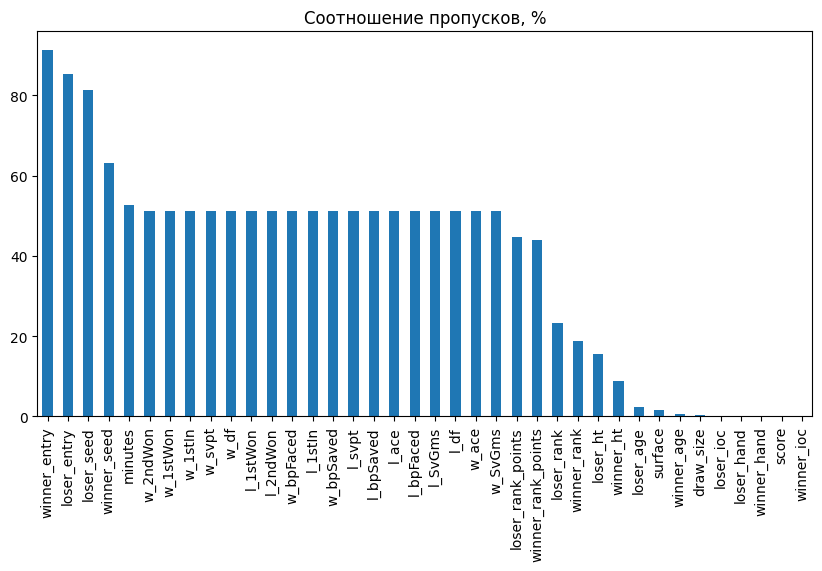

In [16]:
plot_missing_values(combined_df)

In [17]:
# удаляем столбец если у него 60% или более значений отсутствует
combined_df = combined_df.dropna(axis=1, thresh=(0.4 * combined_df.shape[0]))

1. Вы хотите узнать, как много значит ранг игрока в теннисе. Проверьте следующие утверждения:

а) Если ранг игрока выше более, чем на 20 позиций, то в среднем он будет выигрывать с большей вероятностью. (Если хотите проверить статистически — формируйте выборку как отклонение от ожидаемого количества побед при случайном исходе);

Этапы - 
1. Сформировать две выборки игроков: первая выборка - игроки с рангом, отличающимся более чем на 20 позиций от противника, вторая - игроки с близким рангом к противнику (отличие менее 20 позиций). 
2. Для каждой игры в выборках посчитать ожидаемое количество побед при случайном исходе. 
3. Посчитать фактическое количество побед для каждого игрока в выборках.
4. Вычислить отклонение фактического количества побед от ожидаемого для каждого игрока.
5. Рассчитать среднее отклонение для каждой выборки.
6. Сравнить средние отклонения между выборками. Провести статистический тест исходя из критериев. (Нормальность распределения, характеристики критериев, размер выборки и тд)

In [18]:
task_01_a = combined_df[['year', 'match_num', 'winner_id', 'winner_rank', 'loser_id', 'loser_rank']].dropna()
task_01_a['rank_diff_more20'] = np.where(abs(task_01_a['winner_rank'] - task_01_a['loser_rank']) > 20, 1, 0)

# Размеры выборок
task_01_a.rank_diff_more20.value_counts()

rank_diff_more20
1    104578
0     36343
Name: count, dtype: int64

In [22]:
more20 = combined_df[abs(combined_df['winner_rank'] - combined_df['loser_rank']) > 20]
less20 = combined_df[abs(combined_df['winner_rank'] - combined_df['loser_rank']) < 20]
more20.head(3)

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_name,winner_hand,...,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,year
18086,1973-2016,London,Carpet,32.0,A,19731117,1,100119,Ilie Nastase,R,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,88.0,NaN,1973
18087,1973-2016,London,Carpet,32.0,A,19731117,2,100304,Robert Kreiss,R,...,NaN,NaN,NaN,NaN,NaN,193.0,NaN,71.0,NaN,1973
18088,1973-2016,London,Carpet,32.0,A,19731117,3,100135,Onny Parun,R,...,NaN,NaN,NaN,NaN,NaN,39.0,NaN,118.0,NaN,1973


In [23]:
mean_dev_more20 = more20.deviation.abs().mean()
mean_dev_less20 = less20.deviation.abs().mean()

print(f'Cреднее отклонение для выборки more20: {round(mean_dev_more20, 2)}')
print(f'Cреднее отклонение для выборки less20: {round(mean_dev_less20, 2)}')


AttributeError: 'DataFrame' object has no attribute 'deviation'